In [1]:
%load_ext rpy2.ipython

In [5]:
%%R
library(phyloseq)
library(vegan)
library(dplyr)
library(ggplot2)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [4]:
%%R
#install.packages("dplyr")

Installing package into ‘/Users/Thea/Library/R/3.1/library’
(as ‘lib’ is unspecified)
--- Please select a CRAN mirror for use in this session ---
also installing the dependencies ‘assertthat’, ‘R6’, ‘lazyeval’, ‘BH’

trying URL 'http://cran.stat.ucla.edu/src/contrib/assertthat_0.1.tar.gz'
Content type 'application/x-tar' length 10187 bytes
opened URL
downloaded 10187 bytes

trying URL 'http://cran.stat.ucla.edu/src/contrib/R6_2.0.1.tar.gz'
Content type 'application/x-tar' length 120554 bytes (117 Kb)
opened URL
downloaded 117 Kb

trying URL 'http://cran.stat.ucla.edu/src/contrib/lazyeval_0.1.10.tar.gz'
Content type 'application/x-tar' length 20833 bytes (20 Kb)
opened URL
downloaded 20 Kb

trying URL 'http://cran.stat.ucla.edu/src/contrib/BH_1.58.0-1.tar.gz'
Content type 'application/x-tar' length 8727864 bytes (8.3 Mb)
opened URL
downloaded 8.3 Mb

trying URL 'http://cran.stat.ucla.edu/src/contrib/dplyr_0.4.2.tar.gz'
Content type 'application/x-tar' length 642959 bytes (627 Kb)
opened

In [6]:
%%R
physeq = import_biom("../../SeqData/otu_table.tax.meta.biom", parseFunction = parse_taxonomy_greengenes)
md = sample_data(physeq)
physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4858 taxa and 102 samples ]
sample_data() Sample Data:       [ 102 samples by 10 sample variables ]
tax_table()   Taxonomy Table:    [ 4858 taxa by 7 taxonomic ranks ]


In [7]:
%%R
otu_tab = otu_table(physeq) %>% data.frame

In [34]:
%%R
head(otu_tab)

           X1 X67 X67.2 X74.2 X102 X58 X50 X53  X56 X52 X95 X39 X69.2 X104 X49
29_78441   49  19    24    22  130  13  51   9    4   0 122 307    16  142  11
91_58298    0   2     0     0    5   9   1   0    0   9   2   0    14    1   1
93_587720   0   0     3     0    3   0   0   0    0   0   1   0     0    1   1
80_9723   429  58    71   421   21 544 482 548 1397 191  39 195   154  114 319
61_413676  22  13    10     0    5  18  14   0    1   0  21  16     8    9   2
39_168260  32   0     2     4    0   3  37   0    1   3   0  16     0    4   1
          X41 X76.2 X99 X96 X98 X100 X92 X101 X93 X61  X4 X10 X103 X38 X77.2
29_78441   57     5 247 307  75   51  51   44 247   6  66  22  131   2    15
91_58298   65     3  31  17   1    5   3    7  17   1   0   5    4   0     0
93_587720   0     1   1   4   2    4   0    0   3   0   0   0    3   0     0
80_9723   485    79  31  81  11  177  21   54  48 266 291 139  361 149   203
61_413676   0     0   0  22   0    0   5    3   7  20   5   0 

In [35]:
%%R
colnames(otu_tab) = colnames(otu_table(physeq))
head(otu_tab)

            1 67 67.2 74.2 102  58  50  53   56  52  95  39 69.2 104  49  41
29_78441   49 19   24   22 130  13  51   9    4   0 122 307   16 142  11  57
91_58298    0  2    0    0   5   9   1   0    0   9   2   0   14   1   1  65
93_587720   0  0    3    0   3   0   0   0    0   0   1   0    0   1   1   0
80_9723   429 58   71  421  21 544 482 548 1397 191  39 195  154 114 319 485
61_413676  22 13   10    0   5  18  14   0    1   0  21  16    8   9   2   0
39_168260  32  0    2    4   0   3  37   0    1   3   0  16    0   4   1   0
          76.2  99  96 98 100 92 101  93  61   4  10 103  38 77.2   7 97   70
29_78441     5 247 307 75  51 51  44 247   6  66  22 131   2   15 106 34    9
91_58298     3  31  17  1   5  3   7  17   1   0   5   4   0    0   0  3    0
93_587720    1   1   4  2   4  0   0   3   0   0   0   3   0    0   0  0    0
80_9723     79  31  81 11 177 21  54  48 266 291 139 361 149  203 585 47 1479
61_413676    0   0  22  0   0  5   3   7  20   5   0   0  32    0   6  

In [8]:
from cogent.maths.stats.rarefaction import rarefaction
import pandas.rpy.common as com
from numpy import vstack, arange, mean
import pandas as pd

/opt/virt_env/lib/python2.7/site-packages/pandas/rpy/__init__.py:11: FutureWarning: The pandas.rpy module is deprecated and will be removed in a future version. We refer to external packages like rpy2. 
See here for a guide on how to port your code to rpy2: http://pandas.pydata.org/pandas-docs/stable/r_interface.html
  FutureWarning)


In [9]:
def get_raref_vector(data, stride=10, iters=25):
    rare_data = vstack([[len(h.nonzero()[0]) for h in rarefaction(data, stride=stride)] \
                        for i in range(iters)])
    X = arange(stride,data.sum()+stride,stride)
    return X, mean(rare_data, axis=0)

In [38]:
otu_tab = com.load_data("otu_tab")

In [39]:
%%time
# This takes a few minutes
dfs = {}
for sid in otu_tab.columns:
    counts = otu_tab[sid]
    x, raref_data = get_raref_vector(counts, iters=10)
    dfs[sid] = pd.DataFrame(data={"x" : x, "y" : raref_data})  

CPU times: user 1min 23s, sys: 168 ms, total: 1min 24s
Wall time: 1min 24s


In [40]:
d = pd.concat(dfs, axis=0)
d.reset_index(inplace=True)
d.drop(["level_1"], axis=1, inplace=True)
d.rename(columns={"level_0" : "SampleID"}, inplace=True)
d.head()

,SampleID,x,y
0,1,10,9.9
1,1,20,18.8
2,1,30,27.8
3,1,40,35.3
4,1,50,43.1


In [41]:
d = com.convert_to_r_dataframe(d, strings_as_factors=True)
%Rpush d

In [42]:
%%R
d<-data.frame(d)

In [43]:
%%R
md = sample_data(physeq) %>% data.frame %>% add_rownames("SampleID")

In [44]:
%%R
head(md)

Source: local data frame [6 x 11]

  SampleID         DNA Description BarcodeSequence Cosm OrigBarcodes Month
1        1 1.872090888  MIneralDNA    TGTTATCGCACA   12 TGTGCGATAACA     3
2       67 0.648827278  MIneralDNA    AATGTCCGTGAC   42 GTCACGGACATT   2.5
3     67.2 0.648827278  MIneralDNA    TACTTCGCTCGC   42 GCGAGCGAAGTA   2.5
4     74.2 1.292650729  MIneralDNA    GCCTGAATTTAC   16 GTAAATTCAGGC   2.5
5      102 21.62300816  MIneralDNA    GGACCGAACTCA   12 TGAGTTCGGTCC     3
6       58 0.484351505  MIneralDNA    ATGTCGAGAGAA   13 TTCTCTCGACAT   2.5
Variables not shown: LinkerPrimerSequence (chr), Trtmt (chr), MyID (chr), Buff
  (chr)


Joining by: "SampleID"


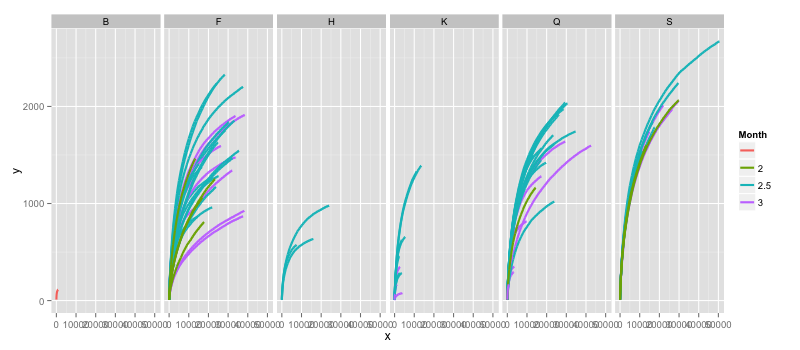

In [45]:
%%R -w 800 -h 350
d.plot = d %>% 
    left_join(md)

p = ggplot(d.plot, aes(x = x, y = y, group = SampleID, color = Month))

p = p + facet_grid(. ~ Trtmt)

p = p + geom_line(size = 1)

p   

Joining by: "SampleID"


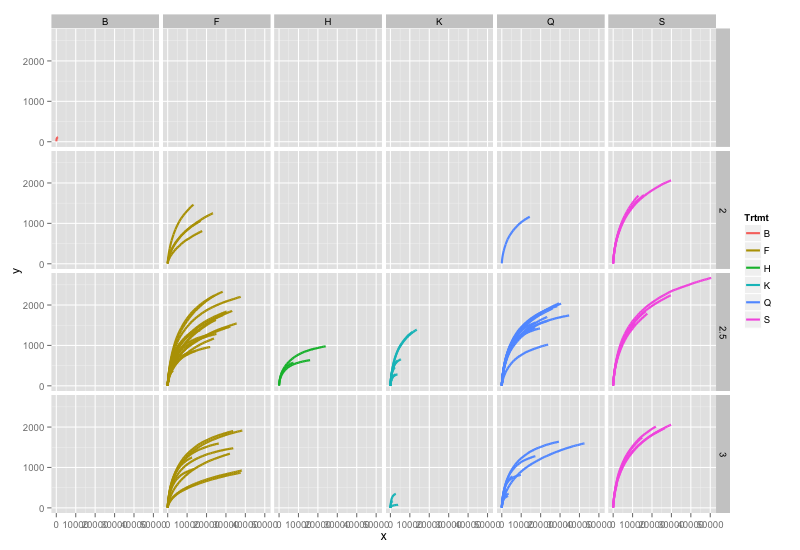

In [46]:
%%R -w 800 -h 550
d.plot = d %>% 
    left_join(md)

p = ggplot(d.plot, aes(x = x, y = y, group = SampleID, color = Trtmt))

p = p + facet_grid(Month ~ Trtmt)

p = p + geom_line(size = 1)

p   